In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import shap
import optuna

# Global Configuration
base_dir = Path().resolve().parent

TUNE_MODE = True # Enable Optuna tuning
N_TRIALS = 20 # Number of trial for Optuna
SEED = 42

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

2025-10-16 23:30:07.384953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 23:30:07.464921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-16 23:30:09.806600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TUNE_MODE: ON | Optuna Trials: 20


In [ ]:
# Step 1: Import the preprocessed data
df_flux = pd.read_csv(base_dir / "dataset/csv/fluxomic_features.csv", index_col=0)

In [ ]:
#  Step 2: Prepare data for ML models

#  2.1 Select the top features and remove Exchange reactions

# Remove exchange reaction
rxns = [c for c in df_flux.columns if c != "response" and not c.startswith("EX_")]
flux = df_flux[rxns]

# Number of top flux features to retain by variance
fl_n = 200
fl_top = flux.var().sort_values(ascending=False).index[:fl_n]

# Build the feature matrix (X) using the selected top fluxes
X = flux[fl_top]

# Extract target column
y = df_flux['response']

#  2.2 Encode target variable
# Convert categorical response labels to numeric (binary classification)
# 'Responder' -> 1, 'Non-responder' -> 0
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)

print(X.shape)

(51831, 200)


In [ ]:
# 2.3 Split the data into training and test sets
# Split dataset into training and test sets (80% train, 20% test)
# Stratified split ensures class balance is preserved in both subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

# 2.4 Standardize the features
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Step 3: Optuna for Hyper-parameter tunning

# 3.1 Optuna Objective Functions with class balance

# Compute class balance ratio
def class_balance(y):
    """
    Compute class imbalance ratio for weighting.
    Returns ratio (negative_count / positive_count).
    Used to compensate for imbalance in binary classification.
    """
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression Objective Function
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Logistic Regression using Optuna.
    Hyperparameter: Regularization strength (C).
    """
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest Objective Function
def tune_rf(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Random Forest using Optuna.
    Tuned hyperparameters include depth, splits, and max features.
    """
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost Objective Function
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning XGBoost using Optuna.
    Includes learning rate, depth, and subsampling parameters.
    """
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Artificial Neural Network (ANN) Objective Function
def tune_ann(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning a simple feed-forward ANN using Optuna.
    The model adapts to class imbalance via sample weighting.
    """
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)


[Responder Class Metrics]
Accuracy     : 53.15
Precision    : 37.31
Recall       : 57.71
F1 Score     : 45.32
ROC AUC Score: 55.35

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.70      0.51      0.59      6879
    Responder       0.37      0.58      0.45      3488

     accuracy                           0.53     10367
    macro avg       0.54      0.54      0.52     10367
 weighted avg       0.59      0.53      0.54     10367



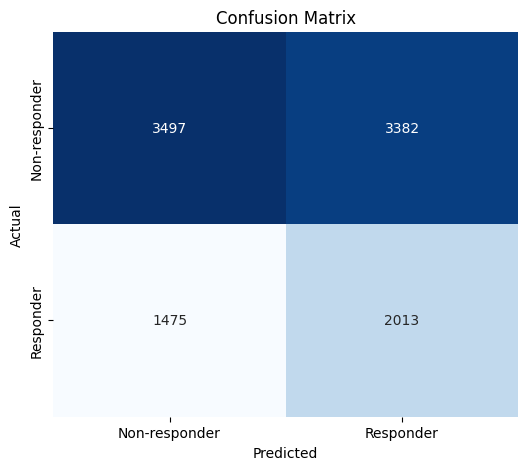

In [ ]:
#  3.2 Run hyperparameter tuning and evaluation for Logistic Regression (LR)

# Step 1: Compute class balance
w = class_balance(y_train)  
print(f"Class balance ratio: neg/pos = {w:.2f}")

# Step 2: Define and run Optuna study
name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study.best_value:.3f} | params={study.best_params}")


# Step 3: Refit model on the full training set by best parameters which obtains by Optuna
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )
model_lr.fit(X_train, y_train)

# Step 4: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred = model_lr.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

#  Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:32:16,409] A new study created in memory with name: no-name-ec2c52c5-8015-4626-9463-70d4f6f27d1c



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:04<?, ?it/s]


Best trial: 0. Best value: 0.59233:   0%|          | 0/20 [00:04<?, ?it/s]


Best trial: 0. Best value: 0.59233:   5%|▌         | 1/20 [00:04<01:25,  4.51s/it]

[I 2025-10-16 23:32:20,919] Trial 0 finished with value: 0.5923300552256605 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.5923300552256605.



Best trial: 0. Best value: 0.59233:   5%|▌         | 1/20 [00:08<01:25,  4.51s/it]


Best trial: 1. Best value: 0.592979:   5%|▌         | 1/20 [00:08<01:25,  4.51s/it]


Best trial: 1. Best value: 0.592979:  10%|█         | 2/20 [00:08<01:17,  4.30s/it]

[I 2025-10-16 23:32:25,069] Trial 1 finished with value: 0.5929788378707737 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5929788378707737.



Best trial: 1. Best value: 0.592979:  10%|█         | 2/20 [00:18<01:17,  4.30s/it]


Best trial: 1. Best value: 0.592979:  10%|█         | 2/20 [00:18<01:17,  4.30s/it]


Best trial: 1. Best value: 0.592979:  15%|█▌        | 3/20 [00:18<01:54,  6.73s/it]

[I 2025-10-16 23:32:34,703] Trial 2 finished with value: 0.5928123271959186 and parameters: {'n_estimators': 600, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5929788378707737.



Best trial: 1. Best value: 0.592979:  15%|█▌        | 3/20 [00:21<01:54,  6.73s/it]


Best trial: 3. Best value: 0.594733:  15%|█▌        | 3/20 [00:21<01:54,  6.73s/it]


Best trial: 3. Best value: 0.594733:  20%|██        | 4/20 [00:21<01:22,  5.19s/it]

[I 2025-10-16 23:32:37,512] Trial 3 finished with value: 0.5947325245206753 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.5947325245206753.



Best trial: 3. Best value: 0.594733:  20%|██        | 4/20 [00:23<01:22,  5.19s/it]


Best trial: 3. Best value: 0.594733:  20%|██        | 4/20 [00:23<01:22,  5.19s/it]


Best trial: 3. Best value: 0.594733:  25%|██▌       | 5/20 [00:23<00:59,  4.00s/it]

[I 2025-10-16 23:32:39,411] Trial 4 finished with value: 0.5891095896210409 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.5947325245206753.



Best trial: 3. Best value: 0.594733:  25%|██▌       | 5/20 [00:30<00:59,  4.00s/it]


Best trial: 3. Best value: 0.594733:  25%|██▌       | 5/20 [00:30<00:59,  4.00s/it]


Best trial: 3. Best value: 0.594733:  30%|███       | 6/20 [00:30<01:10,  5.06s/it]

[I 2025-10-16 23:32:46,544] Trial 5 finished with value: 0.589050091282891 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.5947325245206753.



Best trial: 3. Best value: 0.594733:  30%|███       | 6/20 [00:41<01:10,  5.06s/it]


Best trial: 3. Best value: 0.594733:  30%|███       | 6/20 [00:41<01:10,  5.06s/it]


Best trial: 3. Best value: 0.594733:  35%|███▌      | 7/20 [00:41<01:30,  6.97s/it]

[I 2025-10-16 23:32:57,431] Trial 6 finished with value: 0.589075036946286 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.5947325245206753.



Best trial: 3. Best value: 0.594733:  35%|███▌      | 7/20 [00:54<01:30,  6.97s/it]


Best trial: 7. Best value: 0.594827:  35%|███▌      | 7/20 [00:54<01:30,  6.97s/it]


Best trial: 7. Best value: 0.594827:  40%|████      | 8/20 [00:54<01:50,  9.19s/it]

[I 2025-10-16 23:33:11,366] Trial 7 finished with value: 0.5948270965918232 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.5948270965918232.



Best trial: 7. Best value: 0.594827:  40%|████      | 8/20 [01:13<01:50,  9.19s/it]


Best trial: 8. Best value: 0.596033:  40%|████      | 8/20 [01:13<01:50,  9.19s/it]


Best trial: 8. Best value: 0.596033:  45%|████▌     | 9/20 [01:13<02:14, 12.22s/it]

[I 2025-10-16 23:33:30,256] Trial 8 finished with value: 0.5960329881973795 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.5960329881973795.



Best trial: 8. Best value: 0.596033:  45%|████▌     | 9/20 [01:16<02:14, 12.22s/it]


Best trial: 8. Best value: 0.596033:  45%|████▌     | 9/20 [01:16<02:14, 12.22s/it]


Best trial: 8. Best value: 0.596033:  50%|█████     | 10/20 [01:16<01:31,  9.17s/it]

[I 2025-10-16 23:33:32,601] Trial 9 finished with value: 0.5937880087563838 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 8 with value: 0.5960329881973795.



Best trial: 8. Best value: 0.596033:  50%|█████     | 10/20 [01:36<01:31,  9.17s/it]


Best trial: 8. Best value: 0.596033:  50%|█████     | 10/20 [01:36<01:31,  9.17s/it]


Best trial: 8. Best value: 0.596033:  55%|█████▌    | 11/20 [01:36<01:54, 12.69s/it]

[I 2025-10-16 23:33:53,278] Trial 10 finished with value: 0.5959832271351502 and parameters: {'n_estimators': 800, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.5960329881973795.



Best trial: 8. Best value: 0.596033:  55%|█████▌    | 11/20 [01:57<01:54, 12.69s/it]


Best trial: 8. Best value: 0.596033:  55%|█████▌    | 11/20 [01:57<01:54, 12.69s/it]


Best trial: 8. Best value: 0.596033:  60%|██████    | 12/20 [01:57<02:00, 15.09s/it]

[I 2025-10-16 23:34:13,846] Trial 11 finished with value: 0.5959832271351502 and parameters: {'n_estimators': 800, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.5960329881973795.



Best trial: 8. Best value: 0.596033:  60%|██████    | 12/20 [02:20<02:00, 15.09s/it]


Best trial: 8. Best value: 0.596033:  60%|██████    | 12/20 [02:20<02:00, 15.09s/it]


Best trial: 8. Best value: 0.596033:  65%|██████▌   | 13/20 [02:20<02:02, 17.47s/it]

[I 2025-10-16 23:34:36,793] Trial 12 finished with value: 0.5939198364919233 and parameters: {'n_estimators': 800, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.5960329881973795.



Best trial: 8. Best value: 0.596033:  65%|██████▌   | 13/20 [02:34<02:02, 17.47s/it]


Best trial: 13. Best value: 0.597481:  65%|██████▌   | 13/20 [02:34<02:02, 17.47s/it]


Best trial: 13. Best value: 0.597481:  70%|███████   | 14/20 [02:34<01:39, 16.52s/it]

[I 2025-10-16 23:34:51,114] Trial 13 finished with value: 0.5974812044521821 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  70%|███████   | 14/20 [02:48<01:39, 16.52s/it]


Best trial: 13. Best value: 0.597481:  70%|███████   | 14/20 [02:48<01:39, 16.52s/it]


Best trial: 13. Best value: 0.597481:  75%|███████▌  | 15/20 [02:48<01:17, 15.58s/it]

[I 2025-10-16 23:35:04,503] Trial 14 finished with value: 0.5970673539424894 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  75%|███████▌  | 15/20 [03:01<01:17, 15.58s/it]


Best trial: 13. Best value: 0.597481:  75%|███████▌  | 15/20 [03:01<01:17, 15.58s/it]


Best trial: 13. Best value: 0.597481:  80%|████████  | 16/20 [03:01<00:59, 14.89s/it]

[I 2025-10-16 23:35:17,811] Trial 15 finished with value: 0.5970673539424894 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  80%|████████  | 16/20 [03:17<00:59, 14.89s/it]


Best trial: 13. Best value: 0.597481:  80%|████████  | 16/20 [03:17<00:59, 14.89s/it]


Best trial: 13. Best value: 0.597481:  85%|████████▌ | 17/20 [03:17<00:46, 15.40s/it]

[I 2025-10-16 23:35:34,385] Trial 16 finished with value: 0.5945741553808708 and parameters: {'n_estimators': 600, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  85%|████████▌ | 17/20 [03:31<00:46, 15.40s/it]


Best trial: 13. Best value: 0.597481:  85%|████████▌ | 17/20 [03:31<00:46, 15.40s/it]


Best trial: 13. Best value: 0.597481:  90%|█████████ | 18/20 [03:31<00:29, 14.74s/it]

[I 2025-10-16 23:35:47,602] Trial 17 finished with value: 0.5970673539424894 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  90%|█████████ | 18/20 [03:42<00:29, 14.74s/it]


Best trial: 13. Best value: 0.597481:  90%|█████████ | 18/20 [03:42<00:29, 14.74s/it]


Best trial: 13. Best value: 0.597481:  95%|█████████▌| 19/20 [03:42<00:13, 13.84s/it]

[I 2025-10-16 23:35:59,339] Trial 18 finished with value: 0.5934403977758629 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.



Best trial: 13. Best value: 0.597481:  95%|█████████▌| 19/20 [03:57<00:13, 13.84s/it]


Best trial: 13. Best value: 0.597481:  95%|█████████▌| 19/20 [03:57<00:13, 13.84s/it]


Best trial: 13. Best value: 0.597481: 100%|██████████| 20/20 [03:57<00:00, 14.03s/it]


Best trial: 13. Best value: 0.597481: 100%|██████████| 20/20 [03:57<00:00, 11.87s/it]

[I 2025-10-16 23:36:13,796] Trial 19 finished with value: 0.5974812044521821 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.5974812044521821.
✅ RF best AUC=0.597 | params={'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}



[Responder Class Metrics]
Accuracy     : 53.15
Precision    : 37.31
Recall       : 57.71
F1 Score     : 45.32
ROC AUC Score: 55.35

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.70      0.51      0.59      6879
    Responder       0.37      0.58      0.45      3488

     accuracy                           0.53     10367
    macro avg       0.54      0.54      0.52     10367
 weighted avg       0.59      0.53      0.54     10367



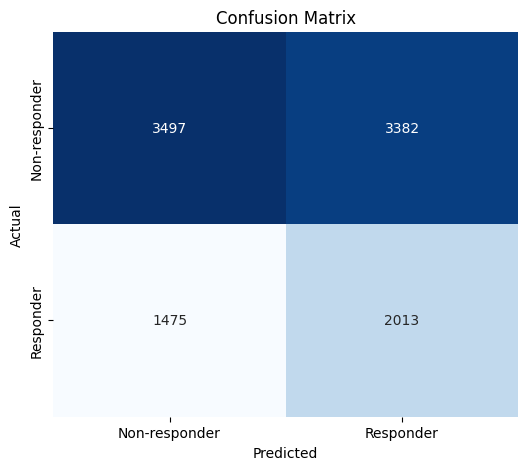

In [ ]:
#  3.3 Run hyperparameter tuning and evaluation for Random Forest (RF)

# Step 1: Define and run Optuna study
name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})
model_rf.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_rf = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_rf = model_lr.predict(X_test)   

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:36:28,181] A new study created in memory with name: no-name-af5e37e6-03a3-45bd-b9d1-e8a958cf69e3



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:56<?, ?it/s]


Best trial: 0. Best value: 0.566736:   0%|          | 0/20 [00:56<?, ?it/s]


Best trial: 0. Best value: 0.566736:   5%|▌         | 1/20 [00:56<17:44, 56.05s/it]

[I 2025-10-16 23:37:24,230] Trial 0 finished with value: 0.5667363582066999 and parameters: {'learning_rate': 0.037541287906256986, 'max_depth': 11, 'subsample': 0.7484091879449571, 'colsample_bytree': 0.7685165500728114, 'n_estimators': 800}. Best is trial 0 with value: 0.5667363582066999.



Best trial: 0. Best value: 0.566736:   5%|▌         | 1/20 [01:05<17:44, 56.05s/it]


Best trial: 0. Best value: 0.566736:   5%|▌         | 1/20 [01:05<17:44, 56.05s/it]


Best trial: 0. Best value: 0.566736:  10%|█         | 2/20 [01:05<08:32, 28.48s/it]

[I 2025-10-16 23:37:33,400] Trial 1 finished with value: 0.5630745237039164 and parameters: {'learning_rate': 0.19427196181942097, 'max_depth': 4, 'subsample': 0.809823734922676, 'colsample_bytree': 0.8363353804083137, 'n_estimators': 600}. Best is trial 0 with value: 0.5667363582066999.



Best trial: 0. Best value: 0.566736:  10%|█         | 2/20 [01:30<08:32, 28.48s/it]


Best trial: 2. Best value: 0.590994:  10%|█         | 2/20 [01:30<08:32, 28.48s/it]


Best trial: 2. Best value: 0.590994:  15%|█▌        | 3/20 [01:30<07:41, 27.13s/it]

[I 2025-10-16 23:37:58,941] Trial 2 finished with value: 0.5909938664931543 and parameters: {'learning_rate': 0.019347644440320146, 'max_depth': 6, 'subsample': 0.7813178254622261, 'colsample_bytree': 0.9582333342181107, 'n_estimators': 1000}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  15%|█▌        | 3/20 [03:10<07:41, 27.13s/it]


Best trial: 2. Best value: 0.590994:  15%|█▌        | 3/20 [03:10<07:41, 27.13s/it]


Best trial: 2. Best value: 0.590994:  20%|██        | 4/20 [03:10<14:54, 55.89s/it]

[I 2025-10-16 23:39:38,904] Trial 3 finished with value: 0.5800676984922528 and parameters: {'learning_rate': 0.010000715440388792, 'max_depth': 12, 'subsample': 0.7583152764623932, 'colsample_bytree': 0.9993822838509441, 'n_estimators': 1000}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  20%|██        | 4/20 [03:29<14:54, 55.89s/it]


Best trial: 2. Best value: 0.590994:  20%|██        | 4/20 [03:29<14:54, 55.89s/it]


Best trial: 2. Best value: 0.590994:  25%|██▌       | 5/20 [03:29<10:40, 42.68s/it]

[I 2025-10-16 23:39:58,159] Trial 4 finished with value: 0.5549170963768866 and parameters: {'learning_rate': 0.23548073930023422, 'max_depth': 9, 'subsample': 0.6989713104318098, 'colsample_bytree': 0.910405966583532, 'n_estimators': 400}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  25%|██▌       | 5/20 [04:01<10:40, 42.68s/it]


Best trial: 2. Best value: 0.590994:  25%|██▌       | 5/20 [04:01<10:40, 42.68s/it]


Best trial: 2. Best value: 0.590994:  30%|███       | 6/20 [04:01<09:03, 38.79s/it]

[I 2025-10-16 23:40:29,395] Trial 5 finished with value: 0.5673102061632072 and parameters: {'learning_rate': 0.06981949813547923, 'max_depth': 9, 'subsample': 0.7292972576218015, 'colsample_bytree': 0.8024968861245341, 'n_estimators': 600}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  30%|███       | 6/20 [04:17<09:03, 38.79s/it]


Best trial: 2. Best value: 0.590994:  30%|███       | 6/20 [04:17<09:03, 38.79s/it]


Best trial: 2. Best value: 0.590994:  35%|███▌      | 7/20 [04:17<06:46, 31.31s/it]

[I 2025-10-16 23:40:45,299] Trial 6 finished with value: 0.559476388571369 and parameters: {'learning_rate': 0.1566373077224119, 'max_depth': 11, 'subsample': 0.7782651300128772, 'colsample_bytree': 0.962936658665863, 'n_estimators': 200}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  35%|███▌      | 7/20 [05:04<06:46, 31.31s/it]


Best trial: 2. Best value: 0.590994:  35%|███▌      | 7/20 [05:04<06:46, 31.31s/it]


Best trial: 2. Best value: 0.590994:  40%|████      | 8/20 [05:04<07:16, 36.40s/it]

[I 2025-10-16 23:41:32,604] Trial 7 finished with value: 0.560404393302578 and parameters: {'learning_rate': 0.11585886501186857, 'max_depth': 12, 'subsample': 0.7380538374081581, 'colsample_bytree': 0.7412769815954312, 'n_estimators': 800}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  40%|████      | 8/20 [05:20<07:16, 36.40s/it]


Best trial: 2. Best value: 0.590994:  40%|████      | 8/20 [05:20<07:16, 36.40s/it]


Best trial: 2. Best value: 0.590994:  45%|████▌     | 9/20 [05:20<05:29, 29.93s/it]

[I 2025-10-16 23:41:48,308] Trial 8 finished with value: 0.5487715074931432 and parameters: {'learning_rate': 0.23146382495315906, 'max_depth': 12, 'subsample': 0.8927717143679346, 'colsample_bytree': 0.9351498224636252, 'n_estimators': 200}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  45%|████▌     | 9/20 [05:40<05:29, 29.93s/it]


Best trial: 2. Best value: 0.590994:  45%|████▌     | 9/20 [05:40<05:29, 29.93s/it]


Best trial: 2. Best value: 0.590994:  50%|█████     | 10/20 [05:40<04:29, 26.96s/it]

[I 2025-10-16 23:42:08,630] Trial 9 finished with value: 0.5601969144233481 and parameters: {'learning_rate': 0.1409031034527941, 'max_depth': 5, 'subsample': 0.6837007424861468, 'colsample_bytree': 0.8661840401047789, 'n_estimators': 1000}. Best is trial 2 with value: 0.5909938664931543.



Best trial: 2. Best value: 0.590994:  50%|█████     | 10/20 [05:59<04:29, 26.96s/it]


Best trial: 10. Best value: 0.594345:  50%|█████     | 10/20 [05:59<04:29, 26.96s/it]


Best trial: 10. Best value: 0.594345:  55%|█████▌    | 11/20 [05:59<03:41, 24.60s/it]

[I 2025-10-16 23:42:27,867] Trial 10 finished with value: 0.5943452154152477 and parameters: {'learning_rate': 0.017529826716661763, 'max_depth': 6, 'subsample': 0.6008364937229934, 'colsample_bytree': 0.6489735769739515, 'n_estimators': 800}. Best is trial 10 with value: 0.5943452154152477.



Best trial: 10. Best value: 0.594345:  55%|█████▌    | 11/20 [06:20<03:41, 24.60s/it]


Best trial: 11. Best value: 0.595358:  55%|█████▌    | 11/20 [06:20<03:41, 24.60s/it]


Best trial: 11. Best value: 0.595358:  60%|██████    | 12/20 [06:20<03:06, 23.33s/it]

[I 2025-10-16 23:42:48,305] Trial 11 finished with value: 0.5953580223755437 and parameters: {'learning_rate': 0.015934887098569786, 'max_depth': 6, 'subsample': 0.6076541237279947, 'colsample_bytree': 0.6228855835485171, 'n_estimators': 800}. Best is trial 11 with value: 0.5953580223755437.



Best trial: 11. Best value: 0.595358:  60%|██████    | 12/20 [06:44<03:06, 23.33s/it]


Best trial: 11. Best value: 0.595358:  60%|██████    | 12/20 [06:44<03:06, 23.33s/it]


Best trial: 11. Best value: 0.595358:  65%|██████▌   | 13/20 [06:44<02:46, 23.72s/it]

[I 2025-10-16 23:43:12,908] Trial 12 finished with value: 0.5897027167325479 and parameters: {'learning_rate': 0.017187066600778542, 'max_depth': 7, 'subsample': 0.6196498156339756, 'colsample_bytree': 0.6284133831055967, 'n_estimators': 800}. Best is trial 11 with value: 0.5953580223755437.



Best trial: 11. Best value: 0.595358:  65%|██████▌   | 13/20 [07:03<02:46, 23.72s/it]


Best trial: 11. Best value: 0.595358:  65%|██████▌   | 13/20 [07:03<02:46, 23.72s/it]


Best trial: 11. Best value: 0.595358:  70%|███████   | 14/20 [07:03<02:12, 22.10s/it]

[I 2025-10-16 23:43:31,266] Trial 13 finished with value: 0.5844966935597853 and parameters: {'learning_rate': 0.03147978843667519, 'max_depth': 7, 'subsample': 0.6122759867977408, 'colsample_bytree': 0.6023516219506635, 'n_estimators': 600}. Best is trial 11 with value: 0.5953580223755437.



Best trial: 11. Best value: 0.595358:  70%|███████   | 14/20 [07:15<02:12, 22.10s/it]


Best trial: 14. Best value: 0.599417:  70%|███████   | 14/20 [07:15<02:12, 22.10s/it]


Best trial: 14. Best value: 0.599417:  75%|███████▌  | 15/20 [07:15<01:35, 19.17s/it]

[I 2025-10-16 23:43:43,649] Trial 14 finished with value: 0.5994170009580958 and parameters: {'learning_rate': 0.010928261495068923, 'max_depth': 4, 'subsample': 0.9991875605341314, 'colsample_bytree': 0.6796879617918679, 'n_estimators': 800}. Best is trial 14 with value: 0.5994170009580958.



Best trial: 14. Best value: 0.599417:  75%|███████▌  | 15/20 [07:24<01:35, 19.17s/it]


Best trial: 15. Best value: 0.602303:  75%|███████▌  | 15/20 [07:24<01:35, 19.17s/it]


Best trial: 15. Best value: 0.602303:  80%|████████  | 16/20 [07:24<01:04, 16.22s/it]

[I 2025-10-16 23:43:53,038] Trial 15 finished with value: 0.6023032728319581 and parameters: {'learning_rate': 0.01032205298278118, 'max_depth': 4, 'subsample': 0.9155394269715391, 'colsample_bytree': 0.6960794307105173, 'n_estimators': 600}. Best is trial 15 with value: 0.6023032728319581.



Best trial: 15. Best value: 0.602303:  80%|████████  | 16/20 [07:31<01:04, 16.22s/it]


Best trial: 15. Best value: 0.602303:  80%|████████  | 16/20 [07:31<01:04, 16.22s/it]


Best trial: 15. Best value: 0.602303:  85%|████████▌ | 17/20 [07:31<00:39, 13.31s/it]

[I 2025-10-16 23:43:59,568] Trial 16 finished with value: 0.5998390255689793 and parameters: {'learning_rate': 0.010871861644993288, 'max_depth': 4, 'subsample': 0.9944334713556287, 'colsample_bytree': 0.7001854931951208, 'n_estimators': 400}. Best is trial 15 with value: 0.6023032728319581.



Best trial: 15. Best value: 0.602303:  85%|████████▌ | 17/20 [07:37<00:39, 13.31s/it]


Best trial: 15. Best value: 0.602303:  85%|████████▌ | 17/20 [07:37<00:39, 13.31s/it]


Best trial: 15. Best value: 0.602303:  90%|█████████ | 18/20 [07:37<00:22, 11.14s/it]

[I 2025-10-16 23:44:05,656] Trial 17 finished with value: 0.5966279390127378 and parameters: {'learning_rate': 0.028059270963432123, 'max_depth': 4, 'subsample': 0.9950119260781362, 'colsample_bytree': 0.7044882689269811, 'n_estimators': 400}. Best is trial 15 with value: 0.6023032728319581.



Best trial: 15. Best value: 0.602303:  90%|█████████ | 18/20 [07:45<00:22, 11.14s/it]


Best trial: 15. Best value: 0.602303:  90%|█████████ | 18/20 [07:45<00:22, 11.14s/it]


Best trial: 15. Best value: 0.602303:  95%|█████████▌| 19/20 [07:45<00:10, 10.10s/it]

[I 2025-10-16 23:44:13,328] Trial 18 finished with value: 0.5916352240583012 and parameters: {'learning_rate': 0.05350005153219187, 'max_depth': 5, 'subsample': 0.9320635524827916, 'colsample_bytree': 0.7189476989238583, 'n_estimators': 400}. Best is trial 15 with value: 0.6023032728319581.



Best trial: 15. Best value: 0.602303:  95%|█████████▌| 19/20 [07:53<00:10, 10.10s/it]


Best trial: 15. Best value: 0.602303:  95%|█████████▌| 19/20 [07:53<00:10, 10.10s/it]


Best trial: 15. Best value: 0.602303: 100%|██████████| 20/20 [07:53<00:00,  9.47s/it]


Best trial: 15. Best value: 0.602303: 100%|██████████| 20/20 [07:53<00:00, 23.66s/it]

[I 2025-10-16 23:44:21,318] Trial 19 finished with value: 0.600901333062383 and parameters: {'learning_rate': 0.012590464945351628, 'max_depth': 5, 'subsample': 0.871318309195785, 'colsample_bytree': 0.6740416150509357, 'n_estimators': 400}. Best is trial 15 with value: 0.6023032728319581.
✅ GB best AUC=0.602 | params={'learning_rate': 0.01032205298278118, 'max_depth': 4, 'subsample': 0.9155394269715391, 'colsample_bytree': 0.6960794307105173, 'n_estimators': 600}



[Responder Class Metrics]
Accuracy     : 54.72
Precision    : 39.14
Recall       : 62.30
F1 Score     : 48.08
ROC AUC Score: 58.93

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.73      0.51      0.60      6879
    Responder       0.39      0.62      0.48      3488

     accuracy                           0.55     10367
    macro avg       0.56      0.57      0.54     10367
 weighted avg       0.61      0.55      0.56     10367



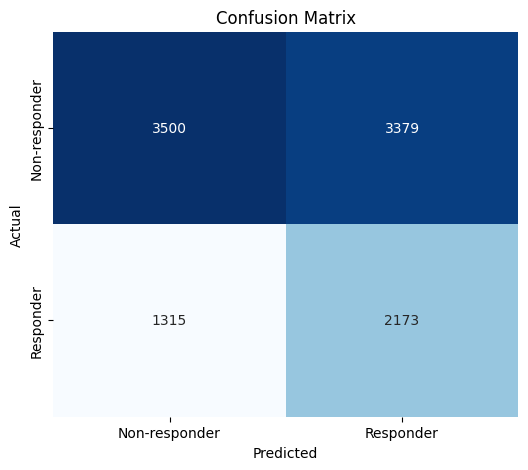

In [ ]:
#  3.4 Run hyperparameter tuning and evaluation for XGBoost (XGB)

# Step 1: Define and run Optuna study
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)
model_gb.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_gb = model_gb.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:44:30,856] A new study created in memory with name: no-name-5ed52a31-c7d5-4cdc-8695-d82b36a53383



  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-16 23:44:30.864555: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step


 61/260 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


119/260 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


182/260 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


244/260 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step



  0%|          | 0/20 [00:13<?, ?it/s]


Best trial: 0. Best value: 0.551377:   0%|          | 0/20 [00:13<?, ?it/s]


Best trial: 0. Best value: 0.551377:   5%|▌         | 1/20 [00:13<04:24, 13.91s/it]

[I 2025-10-16 23:44:44,764] Trial 0 finished with value: 0.5513771243707408 and parameters: {'lr': 0.0008435471422575666, 'dropout': 0.2672838478053462, 'n1': 96, 'n2': 16}. Best is trial 0 with value: 0.5513771243707408.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 57/260 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


104/260 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


164/260 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


226/260 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 0. Best value: 0.551377:   5%|▌         | 1/20 [00:30<04:24, 13.91s/it]


Best trial: 0. Best value: 0.551377:   5%|▌         | 1/20 [00:30<04:24, 13.91s/it]


Best trial: 0. Best value: 0.551377:  10%|█         | 2/20 [00:30<04:33, 15.21s/it]

[I 2025-10-16 23:45:00,893] Trial 1 finished with value: 0.5088621911671509 and parameters: {'lr': 0.008605326390475109, 'dropout': 0.586178648449124, 'n1': 32, 'n2': 16}. Best is trial 0 with value: 0.5513771243707408.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


 69/260 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


 70/260 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


113/260 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


182/260 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


247/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



Best trial: 0. Best value: 0.551377:  10%|█         | 2/20 [00:56<04:33, 15.21s/it]


Best trial: 2. Best value: 0.577607:  10%|█         | 2/20 [00:56<04:33, 15.21s/it]


Best trial: 2. Best value: 0.577607:  15%|█▌        | 3/20 [00:56<05:43, 20.23s/it]

[I 2025-10-16 23:45:27,082] Trial 2 finished with value: 0.5776067729755748 and parameters: {'lr': 0.0003991243974693129, 'dropout': 0.20176025093929778, 'n1': 32, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


 64/260 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


130/260 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


190/260 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


256/260 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step



Best trial: 2. Best value: 0.577607:  15%|█▌        | 3/20 [01:15<05:43, 20.23s/it]


Best trial: 2. Best value: 0.577607:  15%|█▌        | 3/20 [01:15<05:43, 20.23s/it]


Best trial: 2. Best value: 0.577607:  20%|██        | 4/20 [01:15<05:18, 19.89s/it]

[I 2025-10-16 23:45:46,449] Trial 3 finished with value: 0.566529009592031 and parameters: {'lr': 0.0001392493947957969, 'dropout': 0.21886614918998648, 'n1': 64, 'n2': 48}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step


 70/260 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


136/260 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


202/260 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step



Best trial: 2. Best value: 0.577607:  20%|██        | 4/20 [01:39<05:18, 19.89s/it]


Best trial: 2. Best value: 0.577607:  20%|██        | 4/20 [01:39<05:18, 19.89s/it]


Best trial: 2. Best value: 0.577607:  25%|██▌       | 5/20 [01:39<05:19, 21.29s/it]

[I 2025-10-16 23:46:10,236] Trial 4 finished with value: 0.5670187392083952 and parameters: {'lr': 0.0003815937358323035, 'dropout': 0.5514371631556081, 'n1': 128, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


 70/260 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


138/260 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


203/260 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step



Best trial: 2. Best value: 0.577607:  25%|██▌       | 5/20 [01:55<05:19, 21.29s/it]


Best trial: 2. Best value: 0.577607:  25%|██▌       | 5/20 [01:55<05:19, 21.29s/it]


Best trial: 2. Best value: 0.577607:  30%|███       | 6/20 [01:55<04:31, 19.38s/it]

[I 2025-10-16 23:46:25,910] Trial 5 finished with value: 0.5569280555343875 and parameters: {'lr': 0.00022495531113867045, 'dropout': 0.46827843895195254, 'n1': 128, 'n2': 64}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step


 67/260 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


115/260 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


182/260 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


242/260 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 2. Best value: 0.577607:  30%|███       | 6/20 [02:07<04:31, 19.38s/it]


Best trial: 2. Best value: 0.577607:  30%|███       | 6/20 [02:07<04:31, 19.38s/it]


Best trial: 2. Best value: 0.577607:  35%|███▌      | 7/20 [02:07<03:41, 17.05s/it]

[I 2025-10-16 23:46:38,145] Trial 6 finished with value: 0.5339737790465546 and parameters: {'lr': 0.0007623973741199151, 'dropout': 0.5881030968797487, 'n1': 128, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step


 73/260 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


140/260 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


211/260 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step



Best trial: 2. Best value: 0.577607:  35%|███▌      | 7/20 [02:23<03:41, 17.05s/it]


Best trial: 2. Best value: 0.577607:  35%|███▌      | 7/20 [02:23<03:41, 17.05s/it]


Best trial: 2. Best value: 0.577607:  40%|████      | 8/20 [02:23<03:22, 16.86s/it]

[I 2025-10-16 23:46:54,619] Trial 7 finished with value: 0.5673009573793897 and parameters: {'lr': 0.0008026345973809117, 'dropout': 0.40532786303452445, 'n1': 128, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step


 72/260 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


143/260 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


208/260 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step



Best trial: 2. Best value: 0.577607:  40%|████      | 8/20 [02:43<03:22, 16.86s/it]


Best trial: 2. Best value: 0.577607:  40%|████      | 8/20 [02:43<03:22, 16.86s/it]


Best trial: 2. Best value: 0.577607:  45%|████▌     | 9/20 [02:43<03:15, 17.80s/it]

[I 2025-10-16 23:47:14,470] Trial 8 finished with value: 0.5656144221105854 and parameters: {'lr': 0.0004625293842269447, 'dropout': 0.47446327226301377, 'n1': 96, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step


 66/260 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


137/260 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


208/260 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step



Best trial: 2. Best value: 0.577607:  45%|████▌     | 9/20 [02:56<03:15, 17.80s/it]


Best trial: 2. Best value: 0.577607:  45%|████▌     | 9/20 [02:56<03:15, 17.80s/it]


Best trial: 2. Best value: 0.577607:  50%|█████     | 10/20 [02:56<02:42, 16.28s/it]

[I 2025-10-16 23:47:27,356] Trial 9 finished with value: 0.5581302020338206 and parameters: {'lr': 0.0009725938725453528, 'dropout': 0.24608432413414616, 'n1': 64, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


 62/260 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


131/260 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


199/260 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step



Best trial: 2. Best value: 0.577607:  50%|█████     | 10/20 [03:15<02:42, 16.28s/it]


Best trial: 2. Best value: 0.577607:  50%|█████     | 10/20 [03:15<02:42, 16.28s/it]


Best trial: 2. Best value: 0.577607:  55%|█████▌    | 11/20 [03:15<02:33, 17.01s/it]

[I 2025-10-16 23:47:46,030] Trial 10 finished with value: 0.5609892160483334 and parameters: {'lr': 0.0032692107796871905, 'dropout': 0.32144261403348395, 'n1': 32, 'n2': 64}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step


 67/260 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


134/260 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


201/260 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step



Best trial: 2. Best value: 0.577607:  55%|█████▌    | 11/20 [03:32<02:33, 17.01s/it]


Best trial: 2. Best value: 0.577607:  55%|█████▌    | 11/20 [03:32<02:33, 17.01s/it]


Best trial: 2. Best value: 0.577607:  60%|██████    | 12/20 [03:32<02:16, 17.02s/it]

[I 2025-10-16 23:48:03,052] Trial 11 finished with value: 0.5641072611420164 and parameters: {'lr': 0.0023600151494240253, 'dropout': 0.37973282165286215, 'n1': 64, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 63/260 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


136/260 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


206/260 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step



Best trial: 2. Best value: 0.577607:  60%|██████    | 12/20 [03:49<02:16, 17.02s/it]


Best trial: 2. Best value: 0.577607:  60%|██████    | 12/20 [03:49<02:16, 17.02s/it]


Best trial: 2. Best value: 0.577607:  65%|██████▌   | 13/20 [03:49<01:59, 17.10s/it]

[I 2025-10-16 23:48:20,351] Trial 12 finished with value: 0.5572385736812179 and parameters: {'lr': 0.002131610983237636, 'dropout': 0.3700541579588163, 'n1': 96, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step


 68/260 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


138/260 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


202/260 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step



Best trial: 2. Best value: 0.577607:  65%|██████▌   | 13/20 [04:15<01:59, 17.10s/it]


Best trial: 2. Best value: 0.577607:  65%|██████▌   | 13/20 [04:15<01:59, 17.10s/it]


Best trial: 2. Best value: 0.577607:  70%|███████   | 14/20 [04:15<01:59, 19.94s/it]

[I 2025-10-16 23:48:46,837] Trial 13 finished with value: 0.5573120428935145 and parameters: {'lr': 0.0003715762257183489, 'dropout': 0.44656459266444637, 'n1': 32, 'n2': 48}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


 66/260 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


125/260 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


193/260 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step



Best trial: 2. Best value: 0.577607:  70%|███████   | 14/20 [04:38<01:59, 19.94s/it]


Best trial: 2. Best value: 0.577607:  70%|███████   | 14/20 [04:38<01:59, 19.94s/it]

[I 2025-10-16 23:49:08,895] Trial 14 finished with value: 0.5633399377465663 and parameters: {'lr': 0.00010130391585841576, 'dropout': 0.32285345129493076, 'n1': 96, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



Best trial: 2. Best value: 0.577607:  75%|███████▌  | 15/20 [04:38<01:42, 20.58s/it]


  1/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step


 55/260 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


115/260 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


183/260 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step


247/260 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 2. Best value: 0.577607:  75%|███████▌  | 15/20 [04:51<01:42, 20.58s/it]


Best trial: 2. Best value: 0.577607:  75%|███████▌  | 15/20 [04:51<01:42, 20.58s/it]


Best trial: 2. Best value: 0.577607:  80%|████████  | 16/20 [04:51<01:13, 18.34s/it]

[I 2025-10-16 23:49:22,051] Trial 15 finished with value: 0.5586801790095595 and parameters: {'lr': 0.0017323715676200834, 'dropout': 0.4242532575827031, 'n1': 64, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step


 56/260 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


127/260 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


203/260 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step



Best trial: 2. Best value: 0.577607:  80%|████████  | 16/20 [05:18<01:13, 18.34s/it]


Best trial: 2. Best value: 0.577607:  80%|████████  | 16/20 [05:18<01:13, 18.34s/it]


Best trial: 2. Best value: 0.577607:  85%|████████▌ | 17/20 [05:18<01:03, 21.05s/it]

[I 2025-10-16 23:49:49,412] Trial 16 finished with value: 0.5658747558353638 and parameters: {'lr': 0.0002477565484147488, 'dropout': 0.31354850585358157, 'n1': 32, 'n2': 48}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step


 78/260 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


142/260 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


207/260 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step



Best trial: 2. Best value: 0.577607:  85%|████████▌ | 17/20 [05:41<01:03, 21.05s/it]


Best trial: 2. Best value: 0.577607:  85%|████████▌ | 17/20 [05:41<01:03, 21.05s/it]


Best trial: 2. Best value: 0.577607:  90%|█████████ | 18/20 [05:41<00:43, 21.66s/it]

[I 2025-10-16 23:50:12,477] Trial 17 finished with value: 0.5594785705027626 and parameters: {'lr': 0.0005237311098051435, 'dropout': 0.5123563518366485, 'n1': 128, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


 67/260 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


147/260 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


214/260 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step



Best trial: 2. Best value: 0.577607:  90%|█████████ | 18/20 [05:56<00:43, 21.66s/it]


Best trial: 2. Best value: 0.577607:  90%|█████████ | 18/20 [05:56<00:43, 21.66s/it]


Best trial: 2. Best value: 0.577607:  95%|█████████▌| 19/20 [05:56<00:19, 19.73s/it]

[I 2025-10-16 23:50:27,731] Trial 18 finished with value: 0.5360694753008624 and parameters: {'lr': 0.005656923389897808, 'dropout': 0.3606970770970124, 'n1': 96, 'n2': 16}. Best is trial 2 with value: 0.5776067729755748.



  1/260 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step


 69/260 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


140/260 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


209/260 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 2. Best value: 0.577607:  95%|█████████▌| 19/20 [06:11<00:19, 19.73s/it]


Best trial: 2. Best value: 0.577607:  95%|█████████▌| 19/20 [06:11<00:19, 19.73s/it]


Best trial: 2. Best value: 0.577607: 100%|██████████| 20/20 [06:11<00:00, 18.08s/it]


Best trial: 2. Best value: 0.577607: 100%|██████████| 20/20 [06:11<00:00, 18.56s/it]

[I 2025-10-16 23:50:41,964] Trial 19 finished with value: 0.5568620765343374 and parameters: {'lr': 0.001346380084445813, 'dropout': 0.28310002234519865, 'n1': 64, 'n2': 32}. Best is trial 2 with value: 0.5776067729755748.
✅ ANN best AUC=0.578 | params={'lr': 0.0003991243974693129, 'dropout': 0.20176025093929778, 'n1': 32, 'n2': 16}



  1/324 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


 67/324 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


126/324 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


202/324 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


268/324 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step



[Responder Class Metrics]
Accuracy     : 54.48
Precision    : 37.81
Recall       : 54.73
F1 Score     : 44.72
ROC AUC Score: 56.50

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.70      0.54      0.61      6879
    Responder       0.38      0.55      0.45      3488

     accuracy                           0.54     10367
    macro avg       0.54      0.55      0.53     10367
 weighted avg       0.59      0.54      0.56     10367



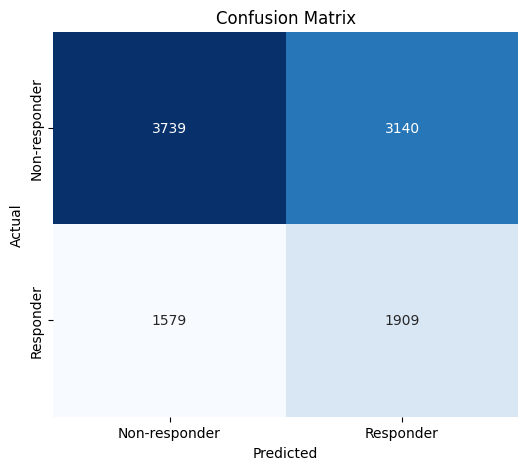

In [ ]:
#  3.5 Run hyperparameter tuning and evaluation for ANN 

# Step 1: Define and run Optuna study
name = 'ANN'
study_ann = optuna.create_study(direction="maximize") 
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"✅ {name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna

# Retrieve best hyperparameters from the ANN Optuna study
best_params = study_ann.best_params

# Compute class imbalance ratio for weighting
w = class_balance(y_train)

#  Build ANN architecture
ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Handle class imbalance via per-sample weighting
sample_weights = np.where(y_train == 1, w, 1)

# Train model
ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# Step 3: Evaluate on test data

# Probability predictions for ROC/AUC
y_prob_ann = ann.predict(X_test)
# Binary predictions using default 0.5 threshold
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


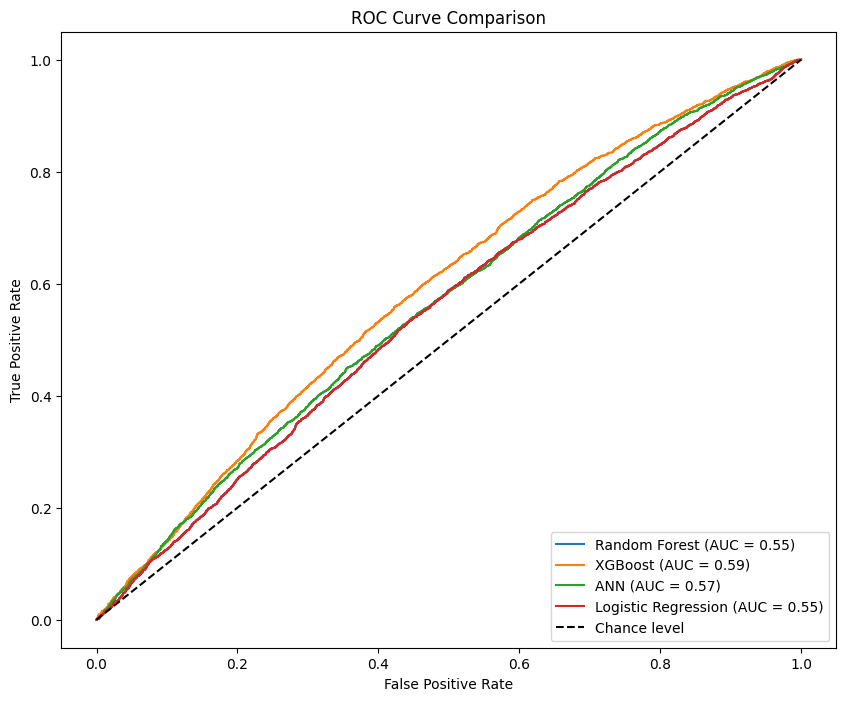

In [ ]:
# Model Comparsion - ROC Curve

# Compute ROC and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

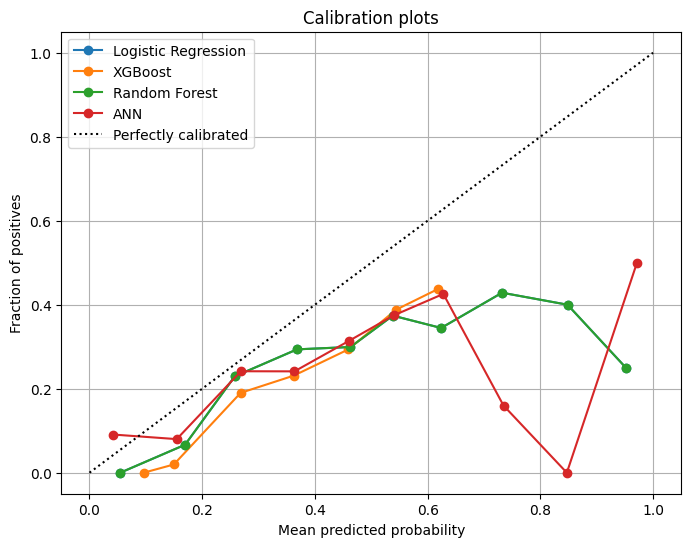

In [ ]:
# Calibration Curver Comparison

# Initialize plot
plt.figure(figsize=(8, 6))

# Define models and their predicted probabilities
for model_name, y_prob in [
    ('Logistic Regression', y_prob),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation using Matthews Correlation Coefficient (MCC)

# Define threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary classes
y_pred_logreg = (y_prob > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Compute MCC for each model
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.0859
MCC - XGBoost: 0.1249
MCC - Random Forest: 0.0808
MCC - ANN: 0.0859


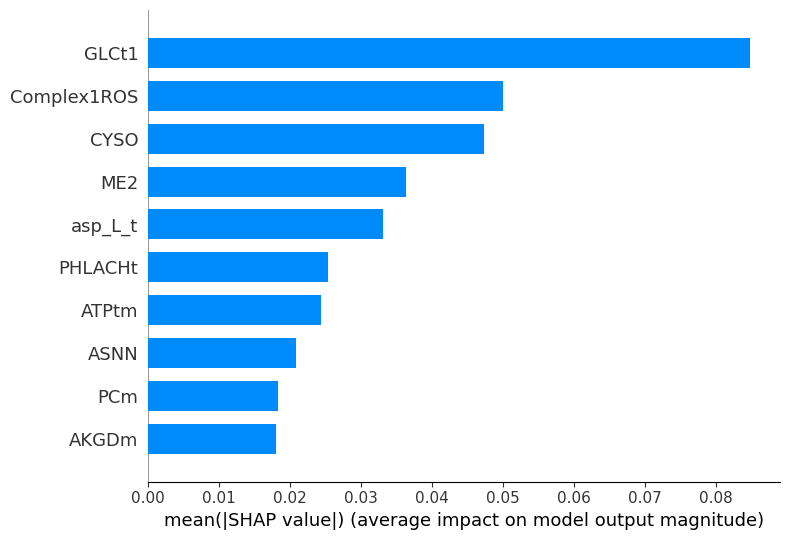

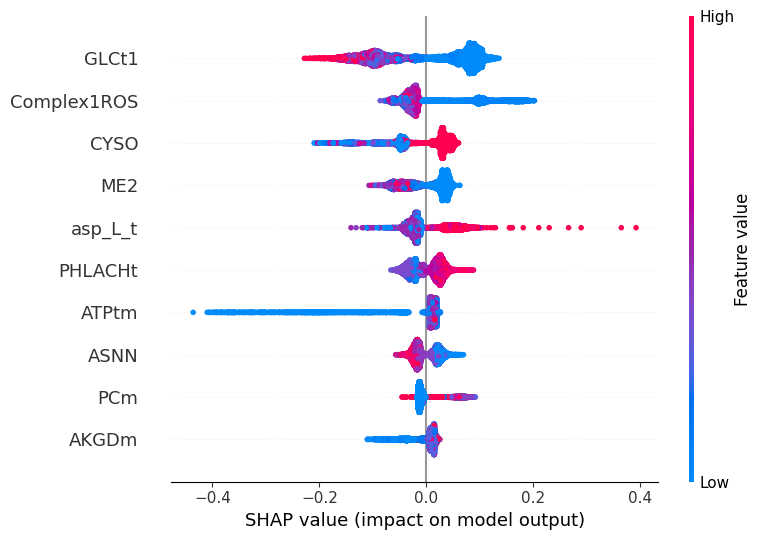

In [ ]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)